In [147]:
import datetime
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.optimize import minimize

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/online-portfolio-selection/misc.py'>

In [170]:
ticker = ["BTC-JPY", "ETH-JPY"]
start_date = "2015-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
prices = df.values
days = df.index.values

[*********************100%***********************]  2 of 2 completed


In [182]:
class OLPS:
    def __init__(self, prices, weights, eta=1.0, lambd=1.0):
        self.prices = prices
        self.rets = prices[1:,:]/prices[:-1,:]
        self.weights = weights
        self.T = prices.shape[0]
        self.n = prices.shape[1]

        self.init_price = 1
        self.start_idx = 0
        self.end_idx = self.T - 1

        self.eta = eta
        self.lambd = lambd
        
    def reset(self):
        self.current_idx = self.start_idx
        self.A = self.lambd * np.eye(self.n)
        self.g = np.zeros(self.n)

    def run(self):
        self.reset()
        current_idx = self.current_idx
        S = np.zeros(self.T)
        w = np.zeros((self.T, self.n))
        S[current_idx] = self.init_price
        w[current_idx] = self.weights
        while True:
            rets = np.dot(w[current_idx], self.rets[current_idx])
            grad = - self.rets[current_idx] / rets
            self.A += np.outer(grad, grad)
            self.g += grad
            current_idx += 1
            S[current_idx] = S[current_idx-1] * rets
            w[current_idx] = self._solve_qp(w[current_idx-1])
            if current_idx == self.end_idx:
                break
        return S, w

    def _solve_qp(self, x0):
        P = self.A
        q = self.eta * self.g
        def obj(x):   return 0.5 * x @ P @ x + q @ x
        def grad(x):  return P @ x + q

        cons = [{'type': 'eq',
                 'fun':  lambda x: np.sum(x) - 1.0,
                 'jac':  lambda x: np.ones_like(x)}]
        bnds = [(0.0, 1.0)] * self.n

        res = minimize(obj, x0=x0, jac=grad,
                       constraints=cons, bounds=bnds,
                       method='SLSQP', options={'maxiter': 100, 'ftol': 1e-9})

        return res.x if res.success else project_simplex(x0 - 0.01 * grad(x0))

    def ftrl(self):
        self.reset()
        current_idx = self.current_idx
        S = np.zeros(self.T)
        w = np.zeros((self.T, self.n))
        S[current_idx] = self.init_price
        w[current_idx] = self.weights
        
        def optimization(idx):
            def obj_func(x):
                y = [-np.log(np.dot(r, x)) for r in self.rets[:idx]]
                obj = np.sum(y) + 0.5 * np.sum(np.power(x, 2))
                return obj
            bnds = [(0.0, 1.0)] * self.n
            cons = [{'type': 'eq', 'fun':  lambda x: np.sum(x) - 1.0}]
            res = minimize(obj_func, x0=self.weights,
                       constraints=cons, bounds=bnds,
                       method='SLSQP', options={'maxiter': 100, 'ftol': 1e-9})
            return res.x if res.success else self.weights
        
        while True:
            rets = np.dot(w[current_idx], self.rets[current_idx])
            current_idx += 1
            S[current_idx] = S[current_idx-1] * rets

            w[current_idx] = optimization(current_idx)
            
            if current_idx == self.end_idx:
                break
        return S, w

    def eg(self):
        self.reset()
        current_idx = self.current_idx
        S = np.zeros(self.T)
        w = np.zeros((self.T, self.n))
        S[current_idx] = self.init_price
        w[current_idx] = self.weights
        while True:
            rets = np.dot(w[current_idx], self.rets[current_idx])
            grad = - self.rets[current_idx] / rets
            current_idx += 1
            S[current_idx] = S[current_idx-1] * rets
            w[current_idx] = w[current_idx-1] * np.exp(-0.1*self.eta * grad)
            w[current_idx] /= np.sum(w[current_idx])
            if current_idx == self.end_idx:
                break
        return S, w

    def benchmark(self):
        self.reset()
        current_idx = self.current_idx
        S = np.zeros(self.T)
        w = np.zeros((self.T, self.n))
        S[current_idx] = self.init_price
        w[current_idx] = self.weights
        while True:
            rets = np.dot(w[current_idx], self.rets[current_idx])
            current_idx += 1
            S[current_idx] = S[current_idx-1] * rets
            w[current_idx] = self.weights
            if current_idx == self.end_idx:
                break
        return S, w

def project_simplex(v):
    # Condat (2016) O(n log n) projection
    v = np.asarray(v, dtype=float)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.where(u * np.arange(1, v.size + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    return np.maximum(v - theta, 0.0)

def best_crp(prices, nit=1000):
    rets = prices[1:]/prices[:-1]
    T = prices.shape[0]
    n = prices.shape[1]

    w = np.ones(n) / n
    for _ in range(nit):
        grad = (rets / (rets @ w)[:,None]).mean(axis=0)
        w_new = project_simplex(w + 0.2 * grad)
        if np.linalg.norm(w_new - w) < 1e-10: break
        w = w_new
    
    current_idx = 0
    S = np.zeros(T)
    S[current_idx] = 1
    while True:
        current_idx += 1
        S[current_idx] = S[current_idx-1] * np.dot(w, rets[current_idx-1])
        if current_idx == T-1:
            break  
    return S, np.tile(w, (T, 1))

def get_Q(prices):
    rets = prices[1:]/prices[:-1]
    T = prices.shape[0]
    
    current_idx = 0
    Q = np.zeros(T)
    Q[current_idx] = 0 
    while True:
        current_idx += 1
        mu = np.sum(rets[:current_idx]) / current_idx
        Q[current_idx] = Q[current_idx-1] + np.linalg.norm(rets[current_idx-1] - mu)**2
        if current_idx == T-1:
            break
    return Q

T = prices.shape[0]
n = prices.shape[1]

"""
gamma = 0.05
prices = np.ones((T, n))
for t in range(T):
    rets = np.array([1 + gamma, 1 - gamma]) if t % 2 == 0 else np.array([1 - gamma, 1 + gamma])
    if t > 0: prices[t] = prices[t-1] * rets
"""

weights = np.array([1, 0])#np.ones(n) / n
model = OLPS(prices, weights)
S, w = model.run()
S_eg, w_eg = model.eg()
S_ftrl, w_ftrl = model.ftrl()
S_ew, w_ew = model.benchmark()
S_crp, w_crp = best_crp(prices)

regret_eg = np.log(S_crp) - np.log(S_eg)
regret_ftrl = np.log(S_crp) - np.log(S_ftrl)
regret = np.log(S_crp) - np.log(S)

Q = get_Q(prices)
logQ = np.log(1 + Q)

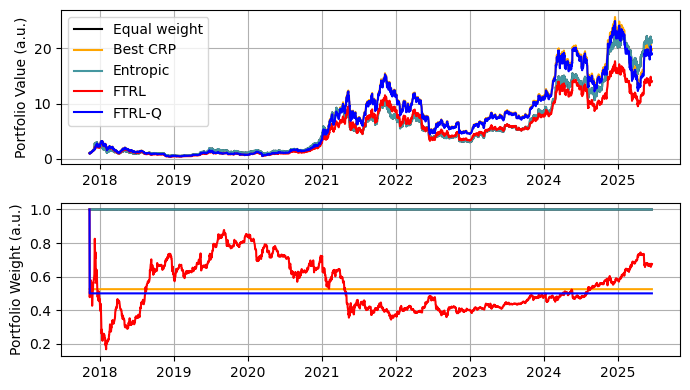

In [187]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), tight_layout=True)
#ax[0].plot(days, prices/prices[0], color="black", alpha=0.5)
ax[0].plot(days, S_ew, color="black", label="Equal weight")
ax[0].plot(days, S_crp, color="orange", label="Best CRP")
ax[0].plot(days, S_eg, color="#4597A0", label="Entropic")
ax[0].plot(days, S_ftrl, color="red", label="FTRL")
ax[0].plot(days, S, color="blue", label="FTRL-Q")
ax[0].set_ylabel("Portfolio Value (a.u.)")
ax[0].legend()
ax[0].grid()
ax[1].plot(days, w_ew[:,0], color="black")
ax[1].plot(days, w_crp[:,0], color="orange")
ax[1].plot(days, w_eg[:,0], color="#4597A0")
ax[1].plot(days, w_ftrl[:,0], color="red")
ax[1].plot(days, w[:,0], color="blue")
ax[1].set_ylabel("Portfolio Weight (a.u.)")
ax[1].grid()
plt.show()

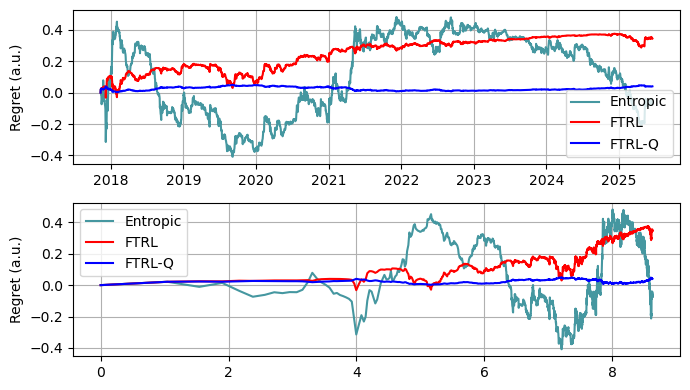

In [184]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), tight_layout=True)
ax[0].plot(days, regret_eg, color="#4597A0", label="Entropic")
ax[0].plot(days, regret_ftrl, color="red", label="FTRL")
ax[0].plot(days, regret, color="blue", label="FTRL-Q")
ax[0].set_ylabel("Regret (a.u.)")
ax[0].legend()
ax[0].grid()
ax[1].plot(logQ, regret_eg, color="#4597A0", label="Entropic")
ax[1].plot(logQ, regret_ftrl, color="red", label="FTRL")
ax[1].plot(logQ, regret, color="blue", label="FTRL-Q")
ax[1].set_ylabel("Regret (a.u.)")
ax[1].legend()
ax[1].grid()
plt.show()

In [185]:
def mean_variance(S):
    rets = np.diff(S) / S[:-1]
    annualized_rets = 100 * np.mean(rets) * 252
    annualized_risk = 100 * np.std(rets, ddof=1) * np.sqrt(252)
    return annualized_rets, annualized_risk

def sharpe_ratio(S):
    rets = np.diff(S) / S[:-1]
    annualized_rets = 100 * np.mean(rets) * 252
    annualized_risk = 100 * np.std(rets, ddof=1) * np.sqrt(252)
    sr = annualized_rets / annualized_risk
    return sr

print(sharpe_ratio(S_eg))
print(sharpe_ratio(S_ftrl))
print(sharpe_ratio(S))  

0.7740239598574336
0.7035770695827113
0.7482652418638488
